# Sentiment analysis

This notebook describes the sentiment analysis steps that were undertaken. In the first part, we extract the sentiment of each quotes. In the second, we provide some descriptive statistics of the final dataset.

## Setup

In [1]:
# Built-in
import os

# Third parties
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
# Initialization needed for some modules

# tqdm for pandas
tqdm.pandas()

# NLTK configuration
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\olivi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# Configuration
DATA_PATH = "data"
PKL_PATH = os.path.join(DATA_PATH, "pkl")
CSV_PATH = os.path.join(DATA_PATH, "csv")
RESOURCES_PATH = os.path.join(DATA_PATH, "resources")

In [4]:
# Utils functions

def get_sentiment(row: pd.Series) -> pd.Series:
    """
    Compute the sentiment score of a given row
    """   
    
    row['NLTK_score'] = sia.polarity_scores(row['quotation'])
    return row

## 1. Compute sentiment score

Since we have all our extracted mentions dataset, we will simply load each year and create a final aggregated dataframe, since it is not too big (around 100k quotes).

In [24]:
df_lst = []

mentions = [os.path.join(CSV_PATH, f"20{i:02d}_mentions.csv") for i in range(15, 21)]  

for mention in mentions:
    df_mention = pd.read_csv(mention)
    df_lst.append(df_mention)

# Concatenate every year together
df = pd.concat(df_lst) 

In [26]:
# Compute the sentiment score
df = df.progress_apply(get_sentiment, axis=1)

100%|██████████| 105929/105929 [01:35<00:00, 1111.21it/s]


Since the computed score is json formatted, we will extract every key of that column and create a new column in the dataset for each.

In [28]:
# Split in columns to get values 
df = pd.concat([df, df['NLTK_score'].progress_apply(pd.Series)], axis=1)

100%|██████████| 105929/105929 [00:23<00:00, 4595.34it/s]


In [29]:
# Sanity check
df.sample(2)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,subset,...,honorificSuffix,fullName,position,stateName,parties,NLTK_score,neg,neu,pos,compound
8830,2017-03-08-013119,as secret as donald trump's tax returns.,lloyd doggett,['Q363817'],2017-03-08 11:30:10,28.0,"[['Lloyd Doggett', '0.8057'], ['None', '0.1471...",['http://gantdaily.com/2017/03/08/house-begins...,E,True,...,II,NaN,Representative,TX,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
10565,2015-11-06-032532,i am disappointed the president today rejected...,kelly ayotte,['Q22354'],2015-11-06 07:25:30,1.0,"[['Kelly Ayotte', '0.6593'], ['None', '0.2289'...",['http://www.wmur.com/politics/hassan-supports...,E,True,...,NaN,kelly ayotte,Senator,NH,Republican,"{'neg': 0.068, 'neu': 0.698, 'pos': 0.234, 'co...",0.068,0.698,0.234,0.9382


In [30]:
# Save the final dataframe both in csv and pickle
df.to_pickle(os.path.join(PKL_PATH, "final_subset.pkl"))
df.to_csv(os.path.join(CSV_PATH, "final_subset.csv"))

Now that we have our final subset, we can conduct our exploratory data analysis on it.

## 2. Sentiment analysis

We will now perform some preliminary analysis, having in mind that we want to analyze the evolution of the sentiment scores accross time. In the first section, we will present some basic descriptive statistics about the data we are working with.

In [5]:
# To avoid running the above cells, we load the dataframe directly
# either from csv or pickle
df = pd.read_pickle(os.path.join(PKL_PATH, "final_subset.pkl"))

### Descriptive statistics

In this section, we simply explore the data we have to deal with. We look at it in an aggregated way, not separated by party.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105929 entries, 0 to 6361
Data columns (total 32 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   quoteID               105929 non-null  object 
 1   quotation             105929 non-null  object 
 2   speaker               105929 non-null  object 
 3   qids                  105929 non-null  object 
 4   date                  105929 non-null  object 
 5   numOccurrences        105929 non-null  float64
 6   probas                105929 non-null  object 
 7   urls                  105929 non-null  object 
 8   phase                 105929 non-null  object 
 9   subset                105929 non-null  bool   
 10  id                    82439 non-null   object 
 11  givenName             105929 non-null  object 
 12  familyName            105929 non-null  object 
 13  unaccentedGivenName   105929 non-null  object 
 14  unaccentedFamilyName  105929 non-null  object 
 15  bi

We see that we have many columns (32!). We decided to keep everything for now, as we might need something. We will scrap some information later on.

In [8]:
df.sample(2)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,subset,...,honorificSuffix,fullName,position,stateName,parties,NLTK_score,neg,neu,pos,compound
21343,2018-08-30-047269,"if john mccain wins, god bless him. if barack ...",john mccain,['Q10390'],2018-08-30 08:28:45,2.0,"[['John McCain', '0.5991'], ['None', '0.3217']...",['http://timesnews.net/Blog/2018/08/30/McCain-...,E,True,...,III,NaN,Senator,AZ,Republican,"{'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'comp...",0.000,0.345,0.655,0.9442
7883,2018-01-23-120890,this is all about the republican incompetence ...,pramila jayapal,['Q18978140'],2018-01-23 21:31:02,2.0,"[['Pramila Jayapal', '0.7793'], ['None', '0.17...",['http://colorlines.com/articles/how-gop-using...,E,True,...,NaN,NaN,Representative,WA,Democrat,"{'neg': 0.324, 'neu': 0.588, 'pos': 0.088, 'co...",0.324,0.588,0.088,-0.8020


Here we see what a small sample of the data looks like.

In [11]:
print("Unique speakers count: ", len(df["speaker"].unique()))

Unique speakers count:  776


This count (776) unique speakers means that not every politician included in the congress biography list was quoted. We should also keep in mind that those are not truly "unique" speakers, since we currently have aliases for Donald Trump. In the future, we will have many more aliases for many of the speaker. Those aliases will be extracted using the `speaker_attributes` file.


In [15]:
trump_aliases = df[df["speaker"].str.contains("trump")]["speaker"].unique()
print("Number of current aliases for Trump: ", len(trump_aliases))
trump_aliases

Number of current aliases for Trump:  3


array(['donald trump', 'president trump', 'president donald trump'],
      dtype=object)

Next, we are interested about the sentiment scores.

In [16]:
sent_lst = ["neg", "neu", "pos", "compound"]
df[sent_lst].describe()

,neg,neu,pos,compound
count,105929.000000,105929.000000,105929.000000,105929.000000
mean,0.085498,0.817413,0.097087,0.046842
std,0.101861,0.127413,0.100218,0.515874
min,0.000000,0.133000,0.000000,-0.996500
25%,0.000000,0.735000,0.000000,-0.361200
50%,0.058000,0.822000,0.081000,0.000000
75%,0.140000,0.909000,0.155000,0.458800
max,0.835000,1.000000,0.756000,0.999000


For our analysis, we decided to only use the `compound` score, as it is the normalized final score of each separate score.
As we can see, most quotes are scored as "neutral". The median is perfectly at 0 and the mean is very similar. Below is the distribution illustrated:

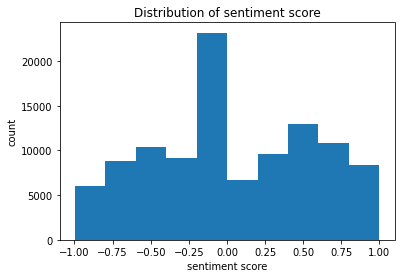

In [24]:
plt.hist(df["compound"]);
plt.title("Distribution of sentiment score");
plt.xlabel("sentiment score");
plt.ylabel("count");

What about its evolution accross time?

In [46]:
df = df.reset_index(drop=True)
df["date"] = pd.to_datetime(df["date"])

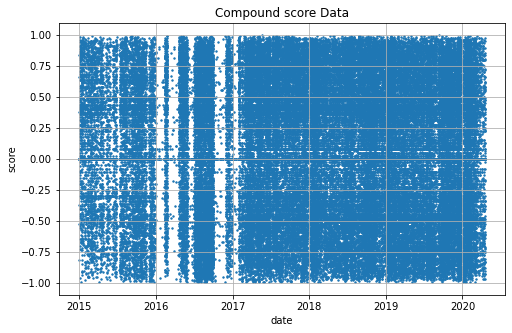

In [58]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(df["date"], df["compound"], s=2)

# Same as above
ax.set_xlabel('date')
ax.set_ylabel('score')
ax.set_title('Compound score Data')
ax.grid(True)

From what we visually see, there seems to be dates with almost no quotes before 2017. This probably comes from the quotebank dataset itself. We will need to keep that in mind when doing our analysis.

To further see if there is a trend with the compound score, we will compute the average per day.

In [126]:
def get_day(date):
    """
    Extract the day date from a datetime object
    """

    date = str(date)
    date = date.split(" ")
    date.pop(-1)
    date = "".join(date)
    
    return pd.to_datetime(date)

In [127]:
# Date is currently precise to the second, but we simply want the date
df["date_simp"] = df["date"].progress_apply(get_day)

100%|██████████| 105929/105929 [00:08<00:00, 12905.33it/s]


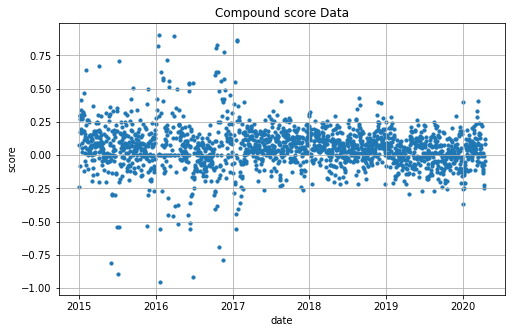

In [128]:
# Plot the average for each day
by_date = df.groupby(["date_simp"])["compound"].mean()

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(by_date.index, by_date, s=10)


# Same as above
ax.set_xlabel('date')
ax.set_ylabel('score')
ax.set_title('Compound score Data')
ax.grid(True)

With the aggregated data, we don't seem to see a trend (maybe a downward trend?). We do see, however, that the variance seem to be higher before 2017. Again, it is clear that this effect comes, in part, from the fact that some days seem to be missing.

We will now further analyze the dataset by exploring different things per party.

### Analysis

In [17]:
# Split the df by party
df_rep = df[df["parties"] == "Republican"]
df_dem = df[df["parties"] == "Democrat"]

In [19]:
print(f"{len(df_rep)=}")
print(f"{len(df_dem)=}")

len(df_rep)=56257
len(df_dem)=49672
